In [4]:
import os
from typing import List, Dict

import nltk
import pandas as pd
import torch
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch.nn as nn
from tqdm import tqdm
import numpy as np
from torch.utils.data.sampler import WeightedRandomSampler

from glove import GloveEmbeddings

nltk.download("punkt")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {DEVICE} device")

# Empty cache
torch.cuda.empty_cache()

Using cuda device


[nltk_data] Downloading package punkt to C:\Users\Rohan
[nltk_data]     Mukherjee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
msr_train = pd.read_csv(
    'data/msr/msr_paraphrase_train.txt', sep='\t', encoding='utf-8', quoting=3
)
msr_test = pd.read_csv(
    'data/msr/msr_paraphrase_test.txt', sep='\t', encoding='utf-8', quoting=3
)

In [6]:
msr_train.head(10)

,Quality,#1 ID,#2 ID,#1 String,#2 String
0,1,702876,702977,"Amrozi accused his brother, whom he called ""th...","Referring to him as only ""the witness"", Amrozi..."
1,0,2108705,2108831,Yucaipa owned Dominick's before selling the ch...,Yucaipa bought Dominick's in 1995 for $693 mil...
2,1,1330381,1330521,They had published an advertisement on the Int...,"On June 10, the ship's owners had published an..."
3,0,3344667,3344648,"Around 0335 GMT, Tab shares were up 19 cents, ...","Tab shares jumped 20 cents, or 4.6%, to set a ..."
4,1,1236820,1236712,"The stock rose $2.11, or about 11 percent, to ...",PG&E Corp. shares jumped $1.63 or 8 percent to...
5,1,738533,737951,Revenue in the first quarter of the year dropp...,With the scandal hanging over Stewart's compan...
6,0,264589,264502,"The Nasdaq had a weekly gain of 17.27, or 1.2 ...",The tech-laced Nasdaq Composite .IXIC rallied ...
7,1,579975,579810,The DVD-CCA then appealed to the state Supreme...,The DVD CCA appealed that decision to the U.S....
8,0,3114205,3114194,"That compared with $35.18 million, or 24 cents...",Earnings were affected by a non-recurring $8 m...
9,1,1355540,1355592,He said the foodservice pie business doesn't f...,"""The foodservice pie business does not fit our..."


In [7]:
parent_dir = os.path.dirname(os.path.abspath("__file__"))
data_dir = os.path.join(parent_dir, "data")

glove_embeddings = GloveEmbeddings(
    path=f"{data_dir}/embeddings/glove.6B/glove.6B.50d.txt"
)

In [8]:
def get_sentence_embedding(
        sentence: str,
        word_embeddings: GloveEmbeddings,
        use_POS: bool = False,
        pos_weights: Dict[str, float] = None,
):
    """
    Compute the sentence embedding using the word embeddings.

    Inputs:
    - sentence: The input sentence
    - word_embeddings: GloveEmbeddings object
    - use_POS: Whether to use POS tagging
    - pos_weights: Dictionary containing POS weights

    Returns:
    torch.Tensor: The sentence embedding
    """
    sentence_embedding = torch.sum(
        torch.stack([
            (pos_weights[tag] if use_POS else 1) * word_embeddings[word]
            for word, tag in nltk.pos_tag(word_tokenize(sentence.lower()))
            if word in word_embeddings.embeddings and (pos_weights is None or tag in pos_weights)
        ]), dim=0
    )
    return sentence_embedding

In [9]:
from sentence_transformers import SentenceTransformer

def get_st_embeddings(
        sentences: List[str],
        st_model: SentenceTransformer,
        batch_size: int = 32,
        device: str = "cpu",
):
    """
    Compute the sentence embedding using the Sentence Transformer model.
    
    Inputs:
    - sentence: The input sentence
    - st_model: SentenceTransformer model
    - batch_size: Encode in batches to avoid memory issues in case multiple sentences are passed
    
    Returns:
    torch.Tensor: The sentence embedding of shape [d,] (when only 1 sentence) or [n, d] where n is the number of sentences and d is the embedding dimension
    """

    st_model.to(device)
    sentence_embeddings = None

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i: i + batch_size]
        batch_embeddings = st_model.encode(batch_sentences, convert_to_tensor=True)
        if sentence_embeddings is None:
            sentence_embeddings = batch_embeddings
        else:
            sentence_embeddings = torch.cat(
                [sentence_embeddings, batch_embeddings], dim=0
            )
    return sentence_embeddings.to("cpu")

C:\Users\Rohan Mukherjee\AppData\Roaming\Python\Python312\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [10]:
def load_msr_data(data_dir: str, split: str):
    msr_data = pd.read_csv(
        f"{data_dir}/msr_paraphrase_{split}.txt", sep="\t", encoding="utf-8", quoting=3
    )
    data = [
        {
            "#1 String": msr_data["#1 String"].values[i],
            "#2 String": msr_data["#2 String"].values[i],
        }
        for i in range(len(msr_data))
    ]
    labels = msr_data["Quality"].values
    return data, labels

In [11]:
msr_path = f'{data_dir}/msr'
train_data, train_labels = load_msr_data(msr_path, "train")
test_data, test_labels = load_msr_data(msr_path, "test")

print(f"Number of Training Examples: {len(train_data)}")
print(f"Number of Test Examples: {len(test_data)}")

Number of Training Examples: 4076
Number of Test Examples: 1725


<Axes: ylabel='count'>

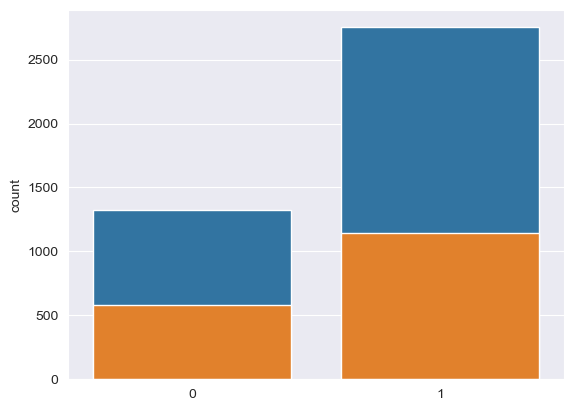

In [12]:
sns.countplot(x=train_labels)
sns.countplot(x=test_labels)

In [13]:
# View a sample of the dataset
print("Example from dataset")
pprint(train_data[69], sort_dicts=False, indent=4)
print(f"Label: {train_labels[69]}")

Example from dataset
{   '#1 String': 'The processors were announced in San Jose at the Intel '
                 'Developer Forum.',
    '#2 String': 'The new processor was unveiled at the Intel Developer Forum '
                 '2003 in San Jose, Calif.'}
Label: 1


In [14]:
def st_embed_msr(msr_data: List[Dict[str, str]], st_model: SentenceTransformer, device: str = "cpu"):
    str1_embedded = get_st_embeddings([example["#1 String"] for example in msr_data], st_model, device=device)
    str2_embedded = get_st_embeddings([example["#2 String"] for example in msr_data], st_model, device=device)
   
    data_embedded = [
        {
            "string1": str1_embedded[i],
            "string2": str2_embedded[i],
        }
        for i in range(len(msr_data))
    ]
    return data_embedded

In [126]:
X_train_glove = [
    {
        "string1": get_sentence_embedding(msr_train["#1 String"].values[i], glove_embeddings, use_POS=False),
        "string2": get_sentence_embedding(msr_train["#2 String"].values[i], glove_embeddings, use_POS=False),
    }
    for i in range(len(msr_train))
]
X_test_glove = [
    {
        "string1": get_sentence_embedding(msr_test["#1 String"].values[i], glove_embeddings, use_POS=False),
        "string2": get_sentence_embedding(msr_test["#2 String"].values[i], glove_embeddings, use_POS=False),
    }
    for i in range(len(msr_test))
]

y_train = msr_train["Quality"].values.astype(np.float32)
y_test = msr_test["Quality"].values.astype(np.float32)

st_model = SentenceTransformer("all-mpnet-base-v2")
if os.path.exists(f"{data_dir}/msr/train_data_embedded.pt") and os.path.exists(f"{data_dir}/msr/test_data_embedded.pt"):
    X_train_st = torch.load(f"{data_dir}/msr/train_data_embedded.pt")
    X_test_st = torch.load(f"{data_dir}/msr/test_data_embedded.pt")
else:
    X_train_st = st_embed_msr(msr_train, st_model, device=DEVICE)
    X_test_st = st_embed_msr(msr_test, st_model, device=DEVICE)
    torch.save(X_train_st, f"{data_dir}/msr/train_data_embedded.pt")
    torch.save(X_test_st, f"{data_dir}/msr/test_data_embedded.pt")

C:\Users\Rohan Mukherjee\AppData\Local\Temp\ipykernel_788624\3062651526.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_train_st = torch.load(f"{data_dir}/msr/train_d

In [16]:
class MSREmbeddedDataset(torch.utils.data.Dataset):
    def __init__(self, data: List[Dict[str, torch.Tensor]], labels: List[float]):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return {
            "string1": self.data[idx]["string1"],
            "string2": self.data[idx]["string2"],
            "label": self.labels[idx]
        }

def get_msr_dataloader(
    embeddings: List[Dict[str, torch.Tensor]],
    labels: List[float],
    batch_size: int = 32,
    shuffle: bool = True,
    use_weighted_sampling: bool = False,
):
    """
    Creates a DataLoader for the MSR dataset, with optional weighted sampling for imbalanced datasets.

    Args:
        embeddings (List[Dict[str, torch.Tensor]]): List of embedded data dictionaries.
        labels (List[float]): List of labels (binary classification: 0 or 1).
        batch_size (int): Size of each batch.
        shuffle (bool): Whether to shuffle the dataset (ignored if weighted sampling is enabled).
        use_weighted_sampling (bool): Whether to use weighted sampling to balance the classes.

    Returns:
        DataLoader: A PyTorch DataLoader for the dataset.
    """
    # Create the dataset
    dataset = MSREmbeddedDataset(embeddings, labels)

    if use_weighted_sampling:
        # Compute class counts
        class_counts = [sum(1 for label in labels if label == 0), sum(1 for label in labels if label == 1)]
        class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float)

        # Assign weights to each sample based on its label
        sample_weights = [class_weights[int(label)] for label in labels]

        # Create a WeightedRandomSampler
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

        # Return DataLoader with sampler
        return DataLoader(dataset, batch_size=batch_size, sampler=sampler, shuffle=shuffle)
    else:
        # Regular DataLoader
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader_glove = get_msr_dataloader(X_train_glove, y_train)
test_loader_glove = get_msr_dataloader(X_test_glove, y_test)
train_loader_st = get_msr_dataloader(X_train_st, y_train)
test_loader_st = get_msr_dataloader(X_test_st, y_test)

In [17]:
for batch in train_loader_glove:
    # Get the embeddings for str1, str2
    str1_batch = batch["string1"]
    str2_batch = batch["string2"]
    labels = batch["label"]

    print(str1_batch.shape, str2_batch.shape, labels.shape)
    break

torch.Size([32, 50]) torch.Size([32, 50]) torch.Size([32])


In [44]:
# Using a Siamese NN architecture
class PNN(torch.nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, hidden_layers: int = 1):
        super(PNN, self).__init__()
        # Shared layers for both strings
        layers = []
        for i in range(hidden_layers):
            in_features = input_dim if i == 0 else hidden_dim
            layers.append(torch.nn.Linear(in_features, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(torch.nn.ReLU())
        self.shared_fc = torch.nn.Sequential(*layers)
        
        # Output layer
        self.fc_out = torch.nn.Linear(hidden_dim * 3, output_dim)

    def forward(self, x1: torch.Tensor, x2: torch.Tensor):
        proj1 = self.shared_fc(x1)
        proj2 = self.shared_fc(x2)
        # Concatenate the two projected embeddings
        x = torch.cat([proj1, proj2, torch.abs(proj1 - proj2)], dim=-1)
        
        return self.fc_out(x)

In [19]:
def accuracy(y_pred, y_true):
    """
    Computes the accuracy of the model.
    
    Args:
        y_pred (torch.Tensor): Predictions from the model.
        y_true (torch.Tensor): True labels.
    
    Returns:
        float: The accuracy of the model.
    """
    correct = (y_pred == y_true).sum().item()
    total = y_true.size(0)
    return correct / total

def precision(y_pred, y_true, epsilon=1e-8):
    """
    Computes the precision of the model.
    
    Args:
        y_pred (torch.Tensor): Predictions from the model.
        y_true (torch.Tensor): True labels.
        epsilon (float): Small value to prevent division by zero.
    
    Returns:
        float: The precision of the model.
    """
    true_positives = (y_pred * y_true).sum().item()
    predicted_positives = y_pred.sum().item()
    return true_positives / (predicted_positives + epsilon)

def recall(y_pred, y_true, epsilon=1e-8):
    """
    Computes the recall of the model.
    
    Args:
        y_pred (torch.Tensor): Predictions from the model.
        y_true (torch.Tensor): True labels.
        epsilon (float): Small value to prevent division by zero.
    
    Returns:
        float: The recall of the model.
    """
    true_positives = (y_pred * y_true).sum().item()
    actual_positives = y_true.sum().item()
    return true_positives / (actual_positives + epsilon)

def f1_score(y_pred, y_true, epsilon=1e-8):
    """
    Computes the F1 score of the model.
    
    Args:
        y_pred (torch.Tensor): Predictions from the model.
        y_true (torch.Tensor): True labels.
        epsilon (float): Small value to prevent division by zero.
    
    Returns:
        float: The F1 score of the model.
    """
    prec = precision(y_pred, y_true, epsilon)
    rec = recall(y_pred, y_true, epsilon)
    return 2 * (prec * rec) / (prec + rec + epsilon)

In [77]:
def evaluate_msr(
    model: PNN,
    dev_data_embedded: List[Dict[str, torch.Tensor]],
    dev_labels: List[float],
    eval_batch_size: int = 128,
    device: str = "cpu",
) -> Dict[str, float]:
    """
    Evaluates the model on the SocialIQA dataset.

    Inputs:
    - model: The ParaphraseNN model
    - dev_data_embedded: List of dictionaries containing the embedded context, question and answers for the validation data
    - dev_labels: List of labels for the validation data
    - eval_batch_size: Batch size for evaluation
    - device: Device to run the evaluation on
    """

    metrics = {
        "loss": 0,
        "accuracy": 0,
        "precision": 0,
        "recall": 0,
        "f1": 0
    }
    
    # true_weight = 1 / (sum(dev_labels) / len(dev_labels))
    # loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([true_weight]).to(device))
    loss_fn = nn.BCEWithLogitsLoss()
    msr_dl = get_msr_dataloader(dev_data_embedded, dev_labels, eval_batch_size, shuffle=False)

    # YOUR CODE HERE
    with torch.no_grad():
        for batch in msr_dl:
            str1 = batch["string1"].to(device)
            str2 = batch["string2"].to(device)
            labels = batch["label"].to(device)
            
            forward = model.forward(str1, str2)
            pred = torch.sigmoid(forward) >= 0.5
            pred = pred.squeeze()
            
            metrics["loss"] += loss_fn(forward.squeeze(), labels).item()
            metrics["accuracy"] += accuracy(pred, labels)
            metrics["precision"] += precision(pred, labels)
            metrics["recall"] += recall(pred, labels)
            metrics["f1"] += f1_score(pred, labels)
    
    metrics["loss"] /= len(msr_dl)
    metrics["accuracy"] /= len(msr_dl)
    metrics["precision"] /= len(msr_dl)
    metrics["recall"] /= len(msr_dl)
    metrics["f1"] /= len(msr_dl)

    return metrics

def train_msr(
    model: PNN,
    train_data_embedded: List[Dict[str, torch.Tensor]],
    train_labels: List[float],
    dev_data_embedded: List[Dict[str, torch.Tensor]],
    dev_labels: List[float],
    lr: float = 1e-3,
    batch_size: int = 32,
    eval_batch_size: int = 128,
    n_epochs: int = 10,
    device: str = "cpu",
    verbose: bool = True,
):
    """
    Runs the training loop for `n_epochs` epochs on the SocialIQA dataset.

    Inputs:
    - model: The ParaphaseNN model to be trained
    - train_data_embedded: List of dictionaries containing the embedded context, question and answers for the training data
    - train_labels: List of labels for the training data
    - dev_data_embedded: List of dictionaries containing the embedded context, question and answers for the validation data
    - dev_labels: List of labels for the validation data
    - lr: Learning rate for the optimizer
    - n_epochs: Number of epochs to train the model

    Returns:
    - train_losses: List of training losses for each epoch
    - dev_metrics: List[Dict[str, float]] of validation metrics (loss, accuracy) for each epoch
    """
    # We remove all the training wheels and let you implement the training loop for the SocialIQA dataset
    # YOUR CODE HERE
    train_dl = get_msr_dataloader(train_data_embedded, train_labels, batch_size, shuffle=True)
    
    # transfer model to device
    model.to(device)
    
    # define CrossEntropy loss function
    # true_weight = 1 / (sum(train_labels) / len(train_labels))
    # loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([true_weight]).to(device))
    loss_fn = nn.BCEWithLogitsLoss()
    
    # Define adam optimizer
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    train_losses = []
    dev_metrics = []
    
    for epoch in range(n_epochs):
        model.train()
        train_epoch_loss = 0.0
        for batch in train_dl:      
            optimizer.zero_grad()
            
            str1 = batch["string1"].to(device)
            str2 = batch["string2"].to(device)
            labels = batch["label"].to(device)
            
            forward = model.forward(str1, str2)
            batch_loss = loss_fn(forward.squeeze(), labels)
            
            # backward pass and update weights
            batch_loss.backward()
            
            # step of optimization
            optimizer.step()
            
            train_epoch_loss += batch_loss.item()
        
        train_epoch_loss /= len(train_dl)
        train_losses.append(train_epoch_loss)
        
        eval_metrics = evaluate_msr(model, dev_data_embedded, dev_labels, eval_batch_size, device)
        dev_metrics.append(eval_metrics)
        
        if verbose:
            print("Epoch: %.d, Train Loss: %.4f, Dev Loss: %.4f, Dev Accuracy: %.4f, Dev Precision: %.4f, Dev Recall: %.4f, Dev F1: %.4f" % (epoch + 1, train_epoch_loss, eval_metrics["loss"], eval_metrics["accuracy"], eval_metrics["precision"], eval_metrics["recall"], eval_metrics["f1"]))

    return train_losses, dev_metrics

In [45]:
# testing train_msr
model = PNN(input_dim=50, hidden_dim=128, output_dim=1)
train_msr(
    model, X_train_glove, y_train, X_test_glove, y_test,
    lr=1e-3, n_epochs=100, batch_size=32, device='cuda', verbose=True
)

Epoch: 1, Train Loss: 0.5989, Dev Loss: 0.5822, Dev Accuracy: 0.6903, Dev Precision: 0.6951, Dev Recall: 0.9512, Dev F1: 0.8024
Epoch: 2, Train Loss: 0.5502, Dev Loss: 0.5641, Dev Accuracy: 0.7228, Dev Precision: 0.7426, Dev Recall: 0.8923, Dev F1: 0.8097
Epoch: 3, Train Loss: 0.5236, Dev Loss: 0.5483, Dev Accuracy: 0.7261, Dev Precision: 0.7466, Dev Recall: 0.8904, Dev F1: 0.8113
Epoch: 4, Train Loss: 0.5002, Dev Loss: 0.5389, Dev Accuracy: 0.7363, Dev Precision: 0.7630, Dev Recall: 0.8742, Dev F1: 0.8140
Epoch: 5, Train Loss: 0.4792, Dev Loss: 0.5401, Dev Accuracy: 0.7351, Dev Precision: 0.7918, Dev Recall: 0.8160, Dev F1: 0.8026
Epoch: 6, Train Loss: 0.4543, Dev Loss: 0.5407, Dev Accuracy: 0.7322, Dev Precision: 0.7510, Dev Recall: 0.8942, Dev F1: 0.8155
Epoch: 7, Train Loss: 0.4411, Dev Loss: 0.5388, Dev Accuracy: 0.7351, Dev Precision: 0.7521, Dev Recall: 0.8970, Dev F1: 0.8173
Epoch: 8, Train Loss: 0.4189, Dev Loss: 0.5338, Dev Accuracy: 0.7300, Dev Precision: 0.7652, Dev Recall:

In [98]:
def train_msr_kfold(
    train_data: List[Dict[str, torch.Tensor]],
    train_labels: List[int],
    hidden_dim: int = 128,
    num_layers: int = 1,
    lr: float = 1e-3,
    n_epochs: int = 10,
    batch_size: int = 32,
    device: str = "cpu",
    verbose: bool = True,
    k: int = 10  # Number of folds
):
    """
    Trains the model using K-fold cross-validation.

    Inputs:
    - train_data: List of dictionaries containing the embedded data for training.
    - train_labels: List of labels for the training data.
    - hidden_dim: Hidden dimension for the model.
    - lr: Learning rate for the optimizer.
    - n_epochs: Number of epochs to train the model.
    - batch_size: Batch size for training.
    - device: Device to run the training on.
    - verbose: Whether to print the training progress.
    - k: Number of folds for cross-validation.

    Returns:
    - train_losses: List of training losses for each fold.
    - dev_metrics: List of validation metrics (loss, accuracy) for each fold.
    """
    train_data = np.array(train_data)
    train_labels = np.array(train_labels)
    
    train_losses = []
    dev_f1s = []

    # K-Fold Cross Validation
    folds = np.array_split(np.arange(len(train_data), dtype=np.int32), k)

    for fold in range(k):
        # Create validation set
        val_idx = folds[fold]
        dev = train_data[val_idx]
        dev_labels_fold = train_labels[val_idx]
    
        # Create training set by excluding validation indices
        train_idx = np.concatenate([folds[i] for i in range(k) if i != fold])
        train = train_data[train_idx]
        train_labels_fold = train_labels[train_idx]

        # Initialize model
        input_dim = train[0]["string1"].shape[0]
        model = PNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1, hidden_layers=num_layers)

        # Train model
        train_loss, dev_metric = train_msr(
            model, train, train_labels_fold, dev, dev_labels_fold,
            lr=lr, n_epochs=n_epochs, batch_size=batch_size, device=device, verbose=False
        )

        # Collect metrics
        train_losses.append(train_loss)
        dev_f1s.append(dev_metric[-1]['f1'])

        if verbose:
            print(f"Fold {fold + 1}/{k}: Train Loss = {train_loss[-1]:.4f}, Dev Loss = {dev_metric[-1]['loss']}, Dev F1 = {dev_metric[-1]['f1']}")

    return np.mean(dev_f1s)

100%|██████████| 10/10 [02:08<00:00, 12.82s/it]


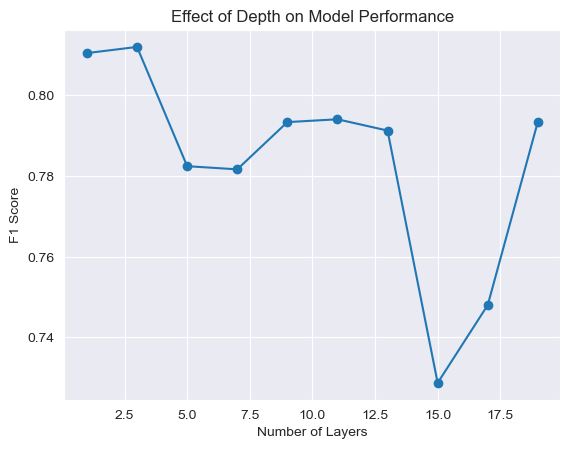

In [110]:
# effect of depth on the model

def get_effect_of_depth_on_model():
    hidden_dim = 1024
    num_layers = np.arange(1, 20, 2)
    f1_scores = []
    
    for layers in tqdm(num_layers):
        model = PNN(input_dim=768, hidden_dim=hidden_dim, output_dim=1, hidden_layers=layers)
        train_losses, dev_metrics = train_msr(model, X_train_st, y_train, X_test_st, y_test, n_epochs=15, device=DEVICE, verbose=False)
        f1_scores.append(dev_metrics[-1]["f1"])
        
    # plot the results
    plt.figure()
    plt.plot(num_layers, f1_scores, marker='o')
    plt.xlabel("Number of Layers")
    plt.ylabel("F1 Score")
    plt.title("Effect of Depth on Model Performance")
    plt.show()

# get_effect_of_depth_on_model()

In [121]:
def tune_hyperparams(input_type: str = "st"):
    hidden_dims = [128, 256, 512, 1024, 2048]
    num_layers = [1, 2, 3, 4]
    lrs = np.logspace(-5, -1, 5)
    n_epochs = np.arange(5, 20, 5)
    batch_sizes = [32, 64, 128]
    best_f1 = 0
    best_params = None
    
    if input_type == "st":
        train_data = X_train_st
    else:
        train_data = X_train_glove
    
    # random search for hyperparameter tuning
    for _ in tqdm(range(30)):
        hidden_dim = np.random.choice(hidden_dims)
        layers = int(np.random.choice(num_layers))
        lr = np.random.choice(lrs)
        n_epoch = int(np.random.choice(n_epochs))
        batch_size = int(np.random.choice(batch_sizes))
    
        f1 = train_msr_kfold(
            train_data=train_data,
            train_labels=y_train,
            hidden_dim=hidden_dim,
            num_layers=layers,
            lr=lr,
            n_epochs=n_epoch,
            batch_size=batch_size,
            device=DEVICE,
            verbose=False
        )
    
        if f1 > best_f1:
            best_f1 = f1
            best_params = {
                "hidden_dim": hidden_dim,
                "num_layers": layers,
                "lr": lr,
                "n_epochs": n_epoch,
                "batch_size": batch_size
            }
            
            print(f"Best F1: {best_f1}")
            print(f"Best Hyperparameters: {best_params}")
    
    print(f"Final Best F1: {best_f1}")
    print(f"Final Best Hyperparameters: {best_params}")
    
    return best_params

# tune_hyperparams("glove")

  3%|▎         | 1/30 [00:14<07:01, 14.52s/it]

Best F1: 0.8018251283753838
Best Hyperparameters: {'hidden_dim': 1024, 'num_layers': 3, 'lr': 0.01, 'n_epochs': 5, 'batch_size': 32}


  7%|▋         | 2/30 [00:28<06:37, 14.18s/it]

Best F1: 0.8067737284345797
Best Hyperparameters: {'hidden_dim': 128, 'num_layers': 3, 'lr': 0.001, 'n_epochs': 5, 'batch_size': 32}


 13%|█▎        | 4/30 [00:51<05:07, 11.81s/it]

Best F1: 0.8166205171607516
Best Hyperparameters: {'hidden_dim': 512, 'num_layers': 2, 'lr': 0.0001, 'n_epochs': 10, 'batch_size': 128}


100%|██████████| 30/30 [08:20<00:00, 16.67s/it]

Final Best F1: 0.8166205171607516
Final Best Hyperparameters: {'hidden_dim': 512, 'num_layers': 2, 'lr': 0.0001, 'n_epochs': 10, 'batch_size': 128}


{'hidden_dim': 512,
 'num_layers': 2,
 'lr': 0.0001,
 'n_epochs': 10,
 'batch_size': 128}

In [1]:
model_with_st = PNN(input_dim=768, hidden_dim=2048, output_dim=1, hidden_layers=1)
model_with_glove = PNN(input_dim=50, hidden_dim=512, output_dim=1, hidden_layers=2)
_ = train_msr(
    model_with_st, X_train_st, y_train, X_test_st, y_test,
    lr=0.001, n_epochs=10, batch_size=128, device='cuda', verbose=True
)
_ = train_msr(
    model_with_glove, X_train_glove, y_train, X_test_glove, y_test,
    lr=0.0001, n_epochs=10, batch_size=128, device='cuda', verbose=True
)

NameError: name 'PNN' is not defined

In [124]:
# predict
def predict(
    model: PNN,
    data: List[Dict[str, str]],
    st_model: SentenceTransformer,
    device: str = "cpu",
):
    """
    Predicts the labels for the data.

    Inputs:
    - model: The ParaphaseNN model
    - data_embedded: List of dictionaries containing the embedded context, question and answers for the data

    Returns:
    - List of predicted labels
    """
    model.to(device)
    model.eval()
    preds = []
    
    data_embedded = st_embed_msr(data, st_model, device=device)
    
    for i in range(len(data_embedded)):
        str1 = data_embedded[i]["string1"].to(device)
        str2 = data_embedded[i]["string2"].to(device)
        if str1.dim() == 1:
            str1 = str1.unsqueeze(0)
            str2 = str2.unsqueeze(0)
        with torch.no_grad():
            forward = model.forward(str1, str2)
            pred = torch.sigmoid(forward) >= 0.5
            preds.append(pred.item())
    return preds

In [128]:
str1 = "I saw meow at the store yesterday"
str2 = "Then I'll meet Meow who will venture to the market tomorrow"
model.eval()
model.to('cpu')

print(predict(model_with_st, [{"#1 String": str1, "#2 String": str2}], st_model, device='cpu'))

[False]


In [129]:
# save model in the msr folder
torch.save(model_with_st.state_dict(), f"{data_dir}/msr/model_st.pth")
torch.save(model_with_glove.state_dict(), f"{data_dir}/msr/model_glove.pth")

In [130]:
# load the model (ST)
model = PNN(input_dim=768, hidden_dim=2048, output_dim=1, hidden_layers=1)
model.load_state_dict(torch.load(f"{data_dir}/msr/model.pth"))
model.to(DEVICE)
model.eval()

# Evaluate the model on the test set
test_metrics = evaluate_msr(model, X_test_st, y_test, device=DEVICE)

# Display test metrics
pprint(test_metrics)

{'accuracy': 0.7496798155737705,
 'f1': 0.8201168703527429,
 'loss': 0.7070094432149615,
 'precision': 0.7817812044318408,
 'recall': 0.8639975912680173}


C:\Users\Rohan Mukherjee\AppData\Local\Temp\ipykernel_788624\3395966179.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{data_dir}/msr

In [131]:
# load the model (Glove)
model = PNN(input_dim=50, hidden_dim=512, output_dim=1, hidden_layers=2)
model.load_state_dict(torch.load(f"{data_dir}/msr/model_glove.pth"))
model.to(DEVICE)
model.eval()

# Evaluate the model on the test set
test_metrics = evaluate_msr(model, X_test_glove, y_test, device=DEVICE)

# Display test metrics
pprint(test_metrics)

{'accuracy': 0.7153103044496488,
 'f1': 0.8073136174754441,
 'loss': 0.5555667792047773,
 'precision': 0.7316298711272615,
 'recall': 0.9029550515510593}


C:\Users\Rohan Mukherjee\AppData\Local\Temp\ipykernel_788624\2573642455.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{data_dir}/msr